In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms,datasets 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.layers(x)

In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

In [4]:
model = YourModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [5]:
def mixup_data(x, y, alpha=1.0):
    batch_size = x.size(0)  # 입력 데이터 x의 배치 사이즈
    lam = torch.rand(batch_size, 1, 1, 1)  # 0~1 사이 랜덤힌 값을 갖는 lam >> mixup 비율
    lam = torch.max(lam, 1-lam)  # 최소값 0.5이상 유지 >> lam, 1-lam 사이 최대값 선택
    mixed_x = lam * x + (1-lam) * x.flip(dims=[0,2,3])  
    # x.flip(dim=[0,2,3]) > 배치차원을 기준으로 뒤집고 (1-lam) 비율을 곱하여 lam*x에 더해줌
    indices = torch.randperm(batch_size)  # batch_size 범위내 랜덤 정수 생성
    mixed_y = lam.squeeze() * y + (1-lam.squeeze()) * y[indices]  # y라벨에 * lam 비율 + 1-lam.squeeze() * 랜덤 y값
    mixed_y = mixed_y.type(torch.long)
    return mixed_x, mixed_y

In [6]:
def plot_imgs(imgs, labels, title):
    fig, axes = plt.subplots(2, 5, figsize=(12,6))
    fig.suptitle(title, fontsize=16)
    labels = labels.numpy()
    for i, ax in enumerate(axes.flat):
        img = imgs[i].squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'label: {labels[i]}')
        ax.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

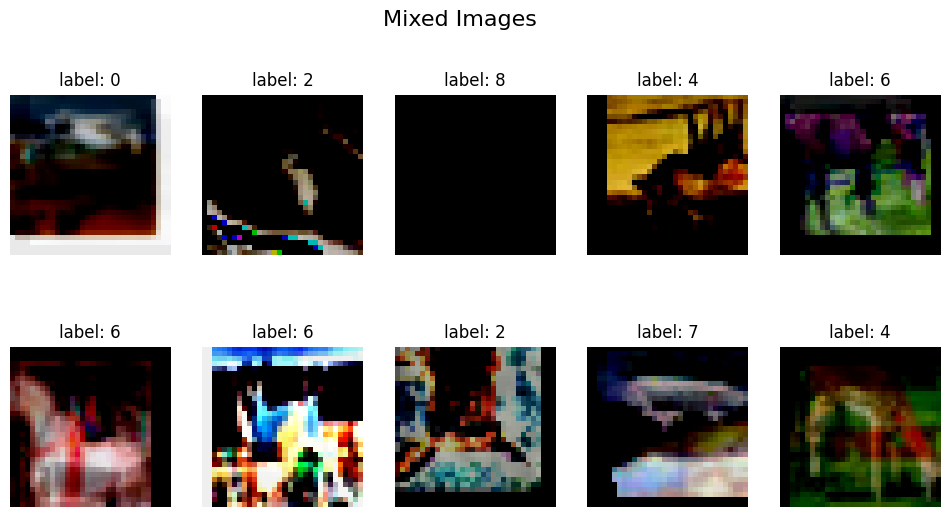

0
1
2
3
4
5
6
7
8
9


In [7]:
num_epochs = 10
train_losses_no_mixup = []
train_losses_with_mixup = []

end_idx = 0
for epoch in range(num_epochs):
    train_loss_no_mixup = 0.0
    train_loss_with_mixup = 0.0
    
    for imgs, labels in train_loader:
        optimizer.zero_grad()
        
        no_mixed_imgs, no_mixed_labels = imgs, labels
        imgs, labels = mixup_data(imgs, labels)
        # 라벨 스무딩을 위한 mixed데이터 생성
        #mixed_x, mixed_y = mixup_data(imgs, labels)
        
        mixed_imgs = imgs.cpu().numpy()
        mixed_imgs = np.transpose(mixed_imgs, (0,2,3,1))
        mixed_imgs = np.squeeze(mixed_imgs)
        
        # 첫번째 배치 시각화
        if end_idx==0:
            plot_imgs(mixed_imgs, labels.squeeze(), 'Mixed Images')
            end_idx = 1
            
        outputs_no_mixup = model(no_mixed_imgs)
        outputs_with_mixup = model(imgs)
        
        labels = torch.squeeze(labels)
        
        loss_no_mixup = criterion(outputs_no_mixup, labels)
        loss_with_mixup = criterion(outputs_with_mixup, labels)
        
        loss_no_mixup.backward()
        loss_with_mixup.backward()
        optimizer.step()
        
        train_loss_no_mixup += loss_no_mixup.item()
        train_loss_with_mixup += loss_with_mixup.item()
    
    train_losses_no_mixup.append(train_loss_no_mixup / len(train_loader))
    train_losses_with_mixup.append(train_loss_with_mixup / len(train_loader))
    
    print(epoch)

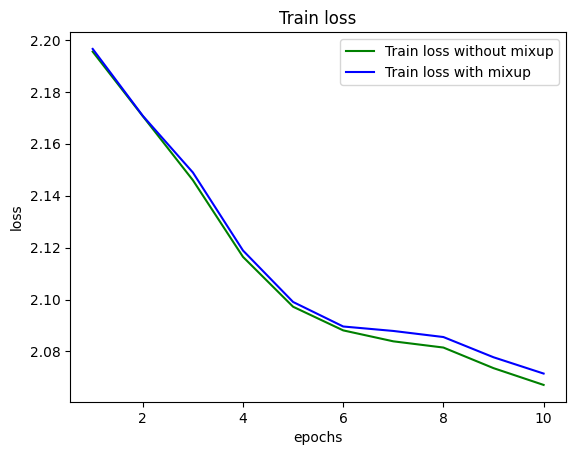

In [9]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses_no_mixup, 'g', label='Train loss without mixup')
plt.plot(epochs, train_losses_with_mixup, 'b', label='Train loss with mixup')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train loss')
plt.legend()
plt.show()